# Project Name
## Project Description
### Data Source

In [73]:
#import libraries
import boto3
import sagemaker
import pandas as pd
import os
import tqdm
import numpy as np

sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")

sm = boto3.Session().client(service_name="sagemaker", region_name=region)
s3 = boto3.Session().client(service_name="s3", region_name=region)

In [74]:
s3_finalprj_csv = "s3://{}/PatientLOS/data/".format(bucket)
print(s3_finalprj_csv)

s3://sagemaker-us-east-1-361019805433/PatientLOS/data/


# Save the training and production data in S3

In [75]:
trainData=pd.read_csv('traindata_medium.csv')
productionData=pd.read_csv('test.csv')
print(trainData.head())
print(productionData.head())

/tmp/ipykernel_138/1347165530.py:1: DtypeWarning: Columns (2,4,6,7,8,12,13,15,17) have mixed types. Specify dtype option on import or set low_memory=False.
  trainData=pd.read_csv('traindata_medium.csv')


   case_id  Hospital_code Hospital_type_code  City_Code_Hospital  \
0      1.0            8.0                  c                 3.0   
1      2.0            2.0                  c                 5.0   
2      3.0           10.0                  e                 1.0   
3      4.0           26.0                  b                 2.0   
4      5.0           26.0                  b                 2.0   

  Hospital_region_code  AvailableExtraRoomsinHospital    Department Ward_Type  \
0                    Z                            3.0  radiotherapy         R   
1                    Z                            2.0  radiotherapy         S   
2                    X                            2.0    anesthesia         S   
3                    Y                            2.0  radiotherapy         R   
4                    Y                            2.0  radiotherapy         S   

  Ward_Facility_Code  BedGrade  patientid  City_Code_Patient TypeofAdmission  \
0                  F    

In [76]:
trainData=trainData.iloc[:10000, :]
productionData=productionData.iloc[:10000,:]
print(trainData.info())
print(productionData.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   case_id                        10000 non-null  float64
 1   Hospital_code                  10000 non-null  float64
 2   Hospital_type_code             10000 non-null  object 
 3   City_Code_Hospital             10000 non-null  float64
 4   Hospital_region_code           10000 non-null  object 
 5   AvailableExtraRoomsinHospital  10000 non-null  float64
 6   Department                     10000 non-null  object 
 7   Ward_Type                      10000 non-null  object 
 8   Ward_Facility_Code             10000 non-null  object 
 9   BedGrade                       9998 non-null   float64
 10  patientid                      10000 non-null  float64
 11  City_Code_Patient              9890 non-null   float64
 12  TypeofAdmission                10000 non-null  

In [82]:
from io import StringIO
import boto3

# Convert DataFrame to CSV and store it in an in-memory buffer
csv_buffer1 = StringIO()
csv_buffer2 = StringIO()
trainData.to_csv(csv_buffer1)
productionData.to_csv(csv_buffer2)


# Define bucket name and object keys (file paths within the bucket)
bucket = 'sagemaker-us-east-1-361019805433'
object_key_train = 'PatientLOS/data/trainData.csv'
object_key_test = 'PatientLOS/data/productionData.csv'

# Initialize the S3 client
s3 = boto3.client('s3')

# Upload the CSV to S3
s3.put_object(Bucket=bucket, Key=object_key_train, Body=csv_buffer1.getvalue())
s3.put_object(Bucket=bucket, Key=object_key_test, Body=csv_buffer2.getvalue())



{'ResponseMetadata': {'RequestId': 'SK0VNV3MEC2E98JB',
  'HostId': 'zr0+FM3mWZbK38sDFmAV4Hs1HRw95EgDeS++FpS2ppJZIDP+6fLsZW4Y6lE775Hnpfbx795tVyafMJl1NTWrxg==',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'zr0+FM3mWZbK38sDFmAV4Hs1HRw95EgDeS++FpS2ppJZIDP+6fLsZW4Y6lE775Hnpfbx795tVyafMJl1NTWrxg==',
   'x-amz-request-id': 'SK0VNV3MEC2E98JB',
   'date': 'Sun, 20 Oct 2024 05:50:04 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"d825f1201e27e2bf6958fb0b6ef5c285"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"d825f1201e27e2bf6958fb0b6ef5c285"',
 'ServerSideEncryption': 'AES256'}

In [83]:
import boto3

s3 = boto3.client('s3')
bucket = 'sagemaker-us-east-1-361019805433'
prefix = 'PatientLOS/data/'

response = s3.list_objects_v2(Bucket=bucket, Prefix=prefix)
for obj in response.get('Contents', []):
    print(obj['Key'])


PatientLOS/data/productionData.csv
PatientLOS/data/trainData.csv


In [85]:
 #code to delete files in th S3 bucket
    
#import boto3

# Initialize the S3 client
#s3 = boto3.client('s3')

# Define the bucket and file keys to delete
#bucket = 'sagemaker-us-east-1-361019805433'
#files_to_delete = [
#    'PatientLOS/data/productionData1.csv',
#    'PatientLOS/data/trainData1.csv'
#]

# Loop through each file and delete it
#for file_key in files_to_delete:
#    response = s3.delete_object(Bucket=bucket, Key=file_key)
#    print(f'Deleted: {file_key}')


In [84]:
# Fetch the CSV file from S3
response = s3.get_object(Bucket=bucket, Key=object_key_train)

# Read the contents of the file
csv_content = response['Body'].read().decode('utf-8')

# Use StringIO to convert the string data into a file-like object for pandas
csv_buffer = StringIO(csv_content)

# Load the CSV data into a pandas DataFrame
trainData = pd.read_csv(csv_buffer)

# Display the DataFrame
print(trainData.head())                  

   Unnamed: 0  case_id  Hospital_code Hospital_type_code  City_Code_Hospital  \
0           0      1.0            8.0                  c                 3.0   
1           1      2.0            2.0                  c                 5.0   
2           2      3.0           10.0                  e                 1.0   
3           3      4.0           26.0                  b                 2.0   
4           4      5.0           26.0                  b                 2.0   

  Hospital_region_code  AvailableExtraRoomsinHospital    Department Ward_Type  \
0                    Z                            3.0  radiotherapy         R   
1                    Z                            2.0  radiotherapy         S   
2                    X                            2.0    anesthesia         S   
3                    Y                            2.0  radiotherapy         R   
4                    Y                            2.0  radiotherapy         S   

  Ward_Facility_Code  BedGrade  

# 2- Data Exploration and Cleaning

In [86]:
trainData.isnull().sum()

Unnamed: 0                         0
case_id                            0
Hospital_code                      0
Hospital_type_code                 0
City_Code_Hospital                 0
Hospital_region_code               0
AvailableExtraRoomsinHospital      0
Department                         0
Ward_Type                          0
Ward_Facility_Code                 0
BedGrade                           2
patientid                          0
City_Code_Patient                110
TypeofAdmission                    0
SeverityofIllness                  0
VisitorswithPatient                0
Age                                0
Admission_Deposit                  0
Stay                               0
dtype: int64

In [87]:
trainData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     10000 non-null  int64  
 1   case_id                        10000 non-null  float64
 2   Hospital_code                  10000 non-null  float64
 3   Hospital_type_code             10000 non-null  object 
 4   City_Code_Hospital             10000 non-null  float64
 5   Hospital_region_code           10000 non-null  object 
 6   AvailableExtraRoomsinHospital  10000 non-null  float64
 7   Department                     10000 non-null  object 
 8   Ward_Type                      10000 non-null  object 
 9   Ward_Facility_Code             10000 non-null  object 
 10  BedGrade                       9998 non-null   float64
 11  patientid                      10000 non-null  float64
 12  City_Code_Patient              9890 non-null   

In [88]:
trainData.describe()

,Unnamed: 0,case_id,Hospital_code,City_Code_Hospital,AvailableExtraRoomsinHospital,BedGrade,patientid,City_Code_Patient,VisitorswithPatient,Admission_Deposit
count,10000.00000,10000.00000,10000.000000,10000.000000,10000.000000,9998.000000,10000.000000,9890.000000,10000.000000,10000.000000
mean,4999.50000,5000.50000,18.874100,4.726600,3.098700,2.642328,66672.653200,6.925480,3.324900,4956.996100
std,2886.89568,2886.89568,8.683351,3.215538,1.145639,0.854936,37533.890048,4.302686,1.874057,1050.393615
min,0.00000,1.00000,1.000000,1.000000,1.000000,1.000000,170.000000,1.000000,1.000000,1979.000000
25%,2499.75000,2500.75000,11.000000,2.000000,2.000000,2.000000,35299.250000,4.000000,2.000000,4278.000000
50%,4999.50000,5000.50000,21.000000,5.000000,3.000000,3.000000,67657.000000,8.000000,3.000000,4834.000000
75%,7499.25000,7500.25000,26.000000,7.000000,4.000000,3.000000,98863.000000,8.000000,4.000000,5471.000000
max,9999.00000,10000.00000,32.000000,13.000000,10.000000,4.000000,131507.000000,34.000000,24.000000,10314.000000


In [89]:
# Change cateorical data to numerical
#Convert the Age column into numerical or ordinal categories for better analysis.
trainData['Age'] = trainData['Age'].replace({
    '0-10': 0, '11-20': 1, '21-30': 2, '31-40': 3, 
    '41-50': 4, '51-60': 5, '61-70': 6, '71-80': 7, 
    '81-90': 8, '91-100': 9
})

print(trainData['Age'].head(20))

0     5
1     5
2     5
3     5
4     5
5     5
6     5
7     5
8     5
9     5
10    5
11    5
12    5
13    5
14    7
15    7
16    7
17    7
18    7
19    7
Name: Age, dtype: object


In [90]:
#imputation using median
trainData['BedGrade'].fillna(trainData['BedGrade'].median(), inplace=True)
trainData['City_Code_Patient'] = trainData.groupby('Hospital_region_code')['City_Code_Patient'].transform(lambda x: x.fillna(x.mode()[0]))
trainData.isnull().sum()

/tmp/ipykernel_138/852459186.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  trainData['BedGrade'].fillna(trainData['BedGrade'].median(), inplace=True)


Unnamed: 0                       0
case_id                          0
Hospital_code                    0
Hospital_type_code               0
City_Code_Hospital               0
Hospital_region_code             0
AvailableExtraRoomsinHospital    0
Department                       0
Ward_Type                        0
Ward_Facility_Code               0
BedGrade                         0
patientid                        0
City_Code_Patient                0
TypeofAdmission                  0
SeverityofIllness                0
VisitorswithPatient              0
Age                              0
Admission_Deposit                0
Stay                             0
dtype: int64

In [93]:
from sklearn.preprocessing import LabelEncoder

# Create a copy of the dataframe to apply transformations
df_transformed = trainData.copy()

# Identify the columns with dtype 'object'
categorical_columns = df_transformed.select_dtypes(include=['object']).columns

# Convert all the categorical columns to strings to ensure uniform data type
df_transformed[categorical_columns] = df_transformed[categorical_columns].astype(str)

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Iterate over each categorical column and apply LabelEncoder
for col in categorical_columns:
    df_transformed[col] = label_encoder.fit_transform(df_transformed[col])

# Display the first few rows to verify the transformation
print(df_transformed.head())

# Optionally, show which columns were transformed
print(f"Transformed columns: {categorical_columns.tolist()}")

   Unnamed: 0  case_id  Hospital_code  Hospital_type_code  City_Code_Hospital  \
0           0      1.0            8.0                   2                 3.0   
1           1      2.0            2.0                   2                 5.0   
2           2      3.0           10.0                   4                 1.0   
3           3      4.0           26.0                   1                 2.0   
4           4      5.0           26.0                   1                 2.0   

   Hospital_region_code  AvailableExtraRoomsinHospital  Department  Ward_Type  \
0                     2                            3.0           3          2   
1                     2                            2.0           3          3   
2                     0                            2.0           1          3   
3                     1                            2.0           3          2   
4                     1                            2.0           3          3   

   Ward_Facility_Code  Bed

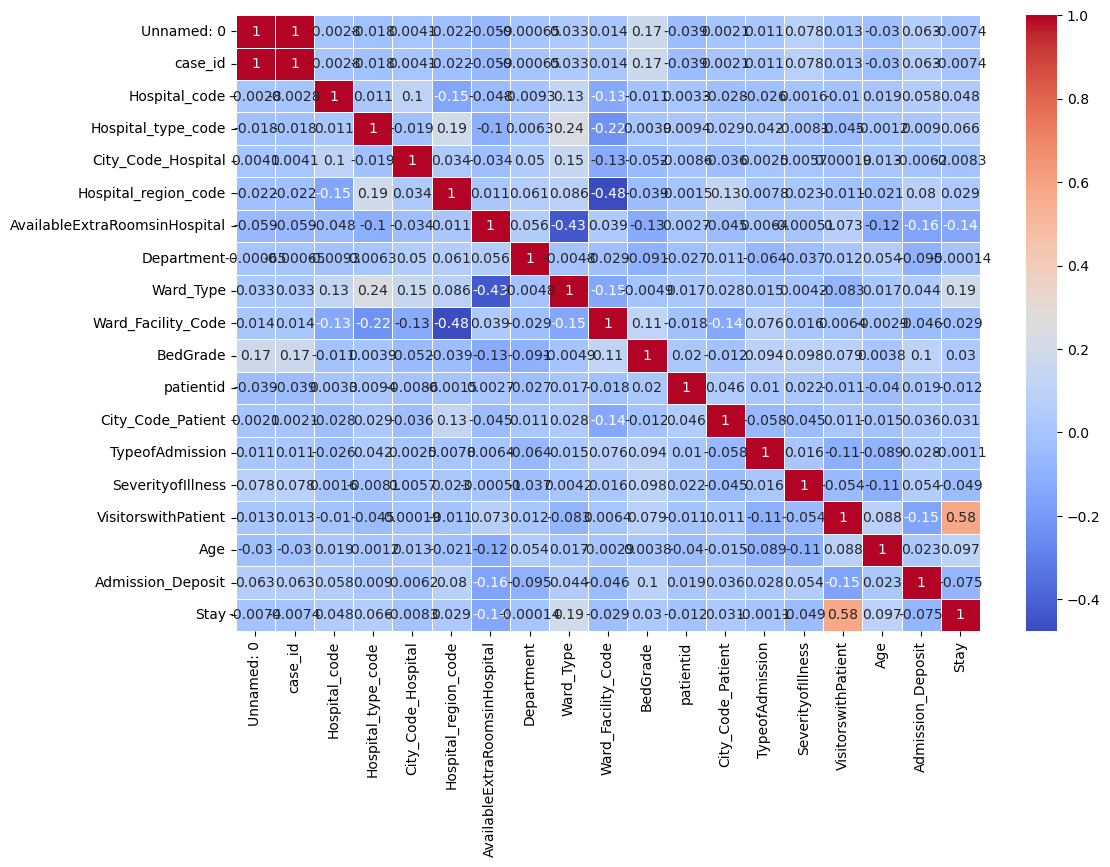

In [94]:
import seaborn as sns
import matplotlib.pyplot as plt

# Drop non-numeric columns from the DataFrame
df_transformed = df_transformed.select_dtypes(include=['number'])

# Generate the correlation matrix (this will only include numeric columns)
corr_matrix = df_transformed.corr()

# Create a heatmap with the correlation matrix
plt.figure(figsize=(12, 8))  # Optional: set the figure size
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)

# Display the plot
plt.show()

# Store processed data to S3 

In [95]:
# This needs to change to our variables names, save train, validate, and test data
from io import StringIO
csv_buffer = StringIO()
df_transformed.to_csv(csv_buffer)

object_key_transformed = 'PatientLOS/data/transformedData.csv'

s3.put_object(Bucket=bucket, Key=object_key_transformed, Body=csv_buffer.getvalue())

{'ResponseMetadata': {'RequestId': '5Y3FRAYGA7YSVFMS',
  'HostId': 'lLrujHJUZu0EF+VvpOVt9Gb67eFyfwxyOQWATZptscUm2dbIt4v4RUJ9OaJCXnRLIPqJQc3vWaIZdW40O2Vtt8YCcTrS3vRqRg99Oa+jL2E=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'lLrujHJUZu0EF+VvpOVt9Gb67eFyfwxyOQWATZptscUm2dbIt4v4RUJ9OaJCXnRLIPqJQc3vWaIZdW40O2Vtt8YCcTrS3vRqRg99Oa+jL2E=',
   'x-amz-request-id': '5Y3FRAYGA7YSVFMS',
   'date': 'Sun, 20 Oct 2024 05:54:21 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"828982193dd5df792232a65d2bad0f38"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"828982193dd5df792232a65d2bad0f38"',
 'ServerSideEncryption': 'AES256'}

# Create Athena database

In [96]:
!pip install -q PyAthena

In [97]:
from pyathena import connect
database_name = "dsoawsfp" # create database name

In [98]:
# Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

In [99]:
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir) # create connection

In [100]:
statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name) # Testing the database
print(statement)

CREATE DATABASE IF NOT EXISTS dsoawsfp


In [101]:
import pandas as pd

pd.read_sql(statement, conn)

/tmp/ipykernel_138/3803073958.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql(statement, conn)


""


In [102]:
statement = "SHOW DATABASES"

df_show = pd.read_sql(statement, conn)
df_show.head(5)

/tmp/ipykernel_138/3999478089.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_show = pd.read_sql(statement, conn)


,database_name
0,default
1,dsoawsfp


# Create Feature Store

In [103]:
from sagemaker.session import Session

region = boto3.Session().region_name

boto_session = boto3.Session(region_name=region)

sagemaker_client = boto_session.client(service_name="sagemaker", region_name=region)
featurestore_runtime = boto_session.client(
    service_name="sagemaker-featurestore-runtime", region_name=region
)

feature_store_session = Session(
    boto_session=boto_session,
    sagemaker_client=sagemaker_client,
    sagemaker_featurestore_runtime_client=featurestore_runtime,
)

In [104]:
# declare bucket name
default_s3_bucket_name = feature_store_session.default_bucket()
prefix = "sagemaker-featurestore-hospitalLOS"

print(default_s3_bucket_name)

sagemaker-us-east-1-361019805433


In [105]:
from sagemaker import get_execution_role

# call for the role information.
role = get_execution_role()
print(role)

arn:aws:iam::361019805433:role/LabRole


In [111]:
# Set Athena parameters
database_name = "dsoawsfp"
table_name_csv = object_key_transformed

In [112]:
statement = """SELECT * FROM {}.{}
    ORDER BY timestamp""".format(
    database_name, table_name_csv
)

print(statement)

SELECT * FROM dsoawsfp.PatientLOS/data/transformedData.csv
    ORDER BY timestamp


# Model Benchmarking

## Basline SVM Model

In [117]:
import numpy as np
# data split in three sets, training, validation and batch inference
rand_split = np.random.rand(len(df_transformed))
train_list = rand_split < 0.66
val_list = (rand_split >= 0.66) & (rand_split < 0.83)
test_list = rand_split >= 0.83

In [123]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Since 'Stay' is the target variable (y) and the rest are features (X)
X = df_transformed.drop(columns=['Stay'])  # Drop the target column
y = df_transformed['Stay']  # Target column

# Split the dataset based on your train, validation, and test lists
X_train = X[train_list]
y_train = y[train_list]

X_val = X[val_list]
y_val = y[val_list]

X_test = X[test_list]
y_test = y[test_list]

# Standardize the data (SVM works better with scaled data)
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Initialize the SVM classifier
svm_model = SVC(kernel='linear')  # You can also experiment with other kernels like 'rbf' or 'poly'

# Train the SVM model on the training set
svm_model.fit(X_train_scaled, y_train)

# Validate the model on the validation set
y_val_pred = svm_model.predict(X_val_scaled)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

# Test the model on the test set
y_test_pred = svm_model.predict(X_test_scaled)
test_accuracysvm = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracysvm * 100:.2f}%")

Validation Accuracy: 40.40%
Test Accuracy: 41.56%


## Xgboost Model

In [120]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 7.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 MB 5.9 MB/s eta 0:00:00:00:0100:01


In [125]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Standardize the data (SVM works better with scaled data)
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
# Initialize and train the XGBoost model
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(y.unique()))

# Train the XGBoost model on the training set
xgb_model.fit(X_train_scaled, y_train)

# Validate the model on the validation set
y_val_pred = xgb_model.predict(X_val_scaled)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"XGBoost Validation Accuracy: {val_accuracy * 100:.2f}%")

# Test the model on the test set
y_test_pred = xgb_model.predict(X_test_scaled)
test_accuracyxgb = accuracy_score(y_test, y_test_pred)
print(f"XGBoost Test Accuracy: {test_accuracyxgb * 100:.2f}%")

# Compare the accuracy with the SVM model accuracy
print(f"SVM Test Accuracy (from previous result): {test_accuracysvm * 100:.2f}%")

XGBoost Validation Accuracy: 40.46%
XGBoost Test Accuracy: 43.02%
SVM Test Accuracy (from previous result): 41.56%


# Ci/CD Pipeline

In [114]:
#!pip install -U sagemaker

In [437]:
import sys
from io import StringIO
import pandas as pd
import boto3
import sagemaker
from sagemaker.workflow.pipeline_context import PipelineSession

sagemaker_session = sagemaker.session.Session()
region = sagemaker_session.boto_region_name
role = sagemaker.get_execution_role()
pipeline_session = PipelineSession()
default_bucket = sagemaker_session.default_bucket()
model_package_group_name = f"HospitalLOS"

In [438]:
s3 = boto3.resource("s3")
local_path_train='traindata_medium.csv'
base_uri = f"s3://{default_bucket}/HospitalLOS"
input_data_uri = sagemaker.s3.S3Uploader.upload(
    local_path=local_path_train,
    desired_s3_uri=base_uri,
)
print(input_data_uri)

s3://sagemaker-us-east-1-361019805433/HospitalLOS/traindata_medium.csv


In [439]:
local_path_test = "test.csv"

s3 = boto3.resource("s3")

base_uri = f"s3://{default_bucket}/HospitalLOS"
batch_data_uri = sagemaker.s3.S3Uploader.upload(
    local_path=local_path_test,
    desired_s3_uri=base_uri,
)
print(batch_data_uri)

s3://sagemaker-us-east-1-361019805433/HospitalLOS/test.csv


In [440]:
import boto3

s3_client = boto3.client('s3')


response = s3_client.list_objects_v2(Bucket=default_bucket, Prefix='HospitalLOS')
for obj in response.get('Contents', []):
    print(obj['Key'])

HospitalLOS/test.csv
HospitalLOS/traindata_medium.csv


In [441]:
# Define Pipeline parameters
from sagemaker.workflow.parameters import (
    ParameterInteger,
    ParameterString,
    ParameterFloat,
)

processing_instance_count = ParameterInteger(name="ProcessingInstanceCount", default_value=1)
instance_type = ParameterString(name="TrainingInstanceType", default_value="ml.m5.xlarge")
model_approval_status = ParameterString(
    name="ModelApprovalStatus", default_value="PendingManualApproval"
)
input_data = ParameterString(
    name="InputData",
    default_value=input_data_uri,
)
batch_data = ParameterString(
    name="BatchData",
    default_value=batch_data_uri,
)
Accuracy_threshold = ParameterFloat(name="Accuracy_Error", default_value=0.6)

In [442]:
#pip install --upgrade sagemaker


In [443]:
from sagemaker.model_card import ModelCard

In [444]:
# %%writefile opt/ml/processing/preprocessing.py
# import argparse
# import os
# import requests
# import tempfile

# import numpy as np
# import pandas as pd

# from sklearn.compose import ColumnTransformer
# from sklearn.impute import SimpleImputer
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler, OneHotEncoder


# # Since we get a headerless CSV file, we specify the column names here.
# # feature_columns_names = [
# #     "case_id" ,                          
# #     "Hospital_code",
# #     "Hospital_type_code",
# #     "City_Code_Hospital",
# #     "Hospital_region_code",
# #     "AvailableExtraRoomsinHospital",
# #     "Department", 
# #     "Ward_Type",
# #     "Ward_Facility_Code",
# #     "BedGrade",
# #     "patientid",
# #     "City_Code_Patient",
# #     "TypeofAdmission",
# #     "SeverityofIllness",
# #     "VisitorswithPatient",
# #     "Age",
# #     "Admission_Deposit" 
# # ]
# # label_column = "Stay"
 
#  # 1   case_id                        10000 non-null  float64
#  # 2   Hospital_code                  10000 non-null  float64
#  # 3   Hospital_type_code             10000 non-null  object 
#  # 4   City_Code_Hospital             10000 non-null  float64
#  # 5   Hospital_region_code           10000 non-null  object 
#  # 6   AvailableExtraRoomsinHospital  10000 non-null  float64
#  # 7   Department                     10000 non-null  object 
#  # 8   Ward_Type                      10000 non-null  object 
#  # 9   Ward_Facility_Code             10000 non-null  object 
#  # 10  BedGrade                       9998 non-null   float64
#  # 11  patientid                      10000 non-null  float64
#  # 12  City_Code_Patient              9890 non-null   float64
#  # 13  TypeofAdmission                10000 non-null  object 
#  # 14  SeverityofIllness              10000 non-null  object 
#  # 15  VisitorswithPatient            10000 non-null  float64
#  # 16  Age                            10000 non-null  object 
#  # 17  Admission_Deposit              10000 non-null  float64
#  # 18  Stay                           10000 non-null  object 
# # feature_columns_dtype = {
# #     "case_id": np.float64,                         
# #     "Hospital_code": np.float64,
# #     "Hospital_type_code": pd.CategoricalDtype(),  # Use CategoricalDtype for categorical columns
# #     "City_Code_Hospital": np.float64,
# #     "Hospital_region_code": pd.CategoricalDtype(),
# #     "AvailableExtraRoomsinHospital": np.float64,
# #     "Department": pd.CategoricalDtype(), 
# #     "Ward_Type": pd.CategoricalDtype(),
# #     "Ward_Facility_Code": pd.CategoricalDtype(),
# #     "BedGrade": np.float64,
# #     "patientid": np.float64,
# #     "City_Code_Patient": np.float64,
# #     "TypeofAdmission": pd.CategoricalDtype(),
# #     "SeverityofIllness": pd.CategoricalDtype(),
# #     "VisitorswithPatient": np.float64,
# #     "Age": pd.CategoricalDtype(),  # Use categorical for age if it's in brackets
# #     "Admission_Deposit": np.float64
# # }

# #label_column_dtype = {"Stay": pd.CategoricalDtype()}

# # def merge_two_dicts(x, y):
# #     z = x.copy()
# #     z.update(y)
# #     return z


# if __name__ == "__main__":
#    # base_dir = "/opt/ml/processing"
# #        base_dir = "/opt/ml/processing"


#     # df = pd.read_csv(
#     #     "opt/ml/processing/input/traindata_medium.csv",
#     #     names=feature_columns_names + [label_column],
#     #     dtype=merge_two_dicts(feature_columns_dtype, label_column_dtype),
#     # )
#     df.read_csv("opt/ml/processing/input/traindata_medium.csv")
#     print(df.head())
#  #   numeric_features = list(feature_columns_names)
#  #   numeric_transformer = Pipeline(
#  #   steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
#  #   )

#     categorical_features = ["Hospital_type_code","Hospital_region_code","Department","Ward_Type","Ward_Facility_Code","TypeofAdmission","SeverityofIllness","Age","Stay"]
#     categorical_transformer = Pipeline(
#         steps=[
#             ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
#             ("onehot", OneHotEncoder(handle_unknown="ignore")),
#         ]
#     )

#     preprocess = ColumnTransformer(
#         transformers=[
#             ("num", numeric_transformer, numeric_features),
#             ("cat", categorical_transformer, categorical_features),
#         ]
#     )

#     y = df.pop("Stay")
#     X_pre = preprocess.fit_transform(df)
#     y_pre = y.to_numpy().reshape(len(y), 1)

#     X = np.concatenate((y_pre, X_pre), axis=1)

#     np.random.shuffle(X)
#     train, validation, test = np.split(X, [int(0.6 * len(X)), int(0.80 * len(X))])

#     pd.DataFrame(train).to_csv("input/train/train.csv", header=False, index=False)
#     pd.DataFrame(validation).to_csv(
#         "input/validation/validation.csv", header=False, index=False
#     )
#     pd.DataFrame(test).to_csv("input/test/test.csv", header=False, index=False)

In [445]:
# %%writefile opt/ml/processing/preprocessing.py
# import argparse
# import os
# import requests
# import tempfile

# import numpy as np
# import pandas as pd

# from sklearn.compose import ColumnTransformer
# from sklearn.impute import SimpleImputer
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler, OneHotEncoder


# # Read CSV file
# if __name__ == "__main__":
    
#     # Reading the input CSV file
#     df = pd.read_csv("/opt/ml/processing/input/traindata_medium.csv")
#     print(df.head())
    
#     # Remove rows with NaN values
#     #df = df.dropna()  # This will remove all rows with any NaN values
    
#     #print("Data after removing NaN values:")
#     #print(df.head())
    
#     # Defining numerical and categorical features
#     numeric_features = [
#         "case_id", "Hospital_code", "City_Code_Hospital", "AvailableExtraRoomsinHospital",
#         "BedGrade", "patientid", "City_Code_Patient", "VisitorswithPatient", "Admission_Deposit"
#     ]
    
#     categorical_features = [
#         "Hospital_type_code", "Hospital_region_code", "Department", "Ward_Type", 
#         "Ward_Facility_Code", "TypeofAdmission", "SeverityofIllness", "Age",'Stay'
#     ]
    
#     # Pipeline for numerical features (imputation and scaling)
#     numeric_transformer = Pipeline(
#         steps=[
#             ("imputer", SimpleImputer(strategy="median")),
#             ("scaler", StandardScaler())
#         ]
#     )
    
#     # Pipeline for categorical features (imputation and one-hot encoding)
#     # categorical_transformer = Pipeline(
#     #     steps=[
#     #         ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
#     #         ("onehot", OneHotEncoder(handle_unknown="ignore"))
#     #     ]
#     # )
#     categorical_transformer = Pipeline(
#        steps=[
#         ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
#         ("labelencoder", OrdinalEncoder())  # Use OrdinalEncoder to convert categories to numerical labels
#         ]
#     )

#     # Combine the transformers into a single preprocessing pipeline
#     preprocess = ColumnTransformer(
#         transformers=[
#             ("num", numeric_transformer, numeric_features),
#             ("cat", categorical_transformer, categorical_features)
#         ]
#     )
    
#     # Separating the target label
#     #y = df.pop("Stay")
    
#     # Fit the preprocessing pipeline and transform the input data
#     df_pre=df.iloc[:10000, :]
#     df_pre = preprocess.fit_transform(df_pre)
#     # Convert the transformed data back to a DataFrame for easier manipulation (optional)
#     df_pre_transformed_df = pd.DataFrame(df_pre_transformed)

#     # Print the shape and first few rows of the transformed data
#     print("Shape of df_pre_transformed:", df_pre_transformed_df.shape)
#     print("First 5 rows of the transformed data:")
#     print(df_pre_transformed_df.head())

#     # Split the dataset based on random values for train, validation, and test
#     rand_split = np.random.rand(len(df_pre_transformed_df))
#     train_list = rand_split < 0.66
#     val_list = (rand_split >= 0.66) & (rand_split < 0.83)
#     test_list = rand_split >= 0.83

#     # Split the dataset into train, validation, and test sets
#     df_train = df_pre_transformed_df[train_list]
#     df_val = df_pre_transformed_df[val_list]
#     df_test = df_pre_transformed_df[test_list]    # Create directories for output if they don't exist
#     os.makedirs("/opt/ml/processing/output/train", exist_ok=True)
#     os.makedirs("/opt/ml/processing/output/validation", exist_ok=True)
#     os.makedirs("/opt/ml/processing/output/test", exist_ok=True)

#     # Print confirmation of directory creation
#     print("Directories created successfully.")      

#     # Save the processed data to CSV files
#     pd.DataFrame(df_train).to_csv("/opt/ml/processing/output/train/train.csv", index=False)
#     pd.DataFrame(df_val).to_csv("/opt/ml/processing/output/validation/validation.csv", index=False)
#     pd.DataFrame(df_test).to_csv("/opt/ml/processing/output/test/test.csv", index=False)


In [515]:
%%writefile opt/ml/processing/preprocessing.py
import argparse
import os
import requests
import tempfile

import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

# Read CSV file
if __name__ == "__main__":

    # Reading the input CSV file
    df = pd.read_csv("/opt/ml/processing/input/traindata_medium.csv")
    print(df.head())

    # Defining numerical and categorical features
    numeric_features = [
        "case_id", "Hospital_code", "City_Code_Hospital", "AvailableExtraRoomsinHospital",
        "BedGrade", "patientid", "City_Code_Patient", "VisitorswithPatient", "Admission_Deposit"
    ]

    categorical_features = [
        "Hospital_type_code", "Hospital_region_code", "Department", "Ward_Type", 
        "Ward_Facility_Code", "TypeofAdmission", "SeverityofIllness", "Age", 'Stay'
    ]

    # Pipeline for numerical features (imputation and scaling)
    numeric_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]
    )

    # Pipeline for categorical features (imputation and label encoding)
    categorical_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
            ("labelencoder", OrdinalEncoder())  # Use OrdinalEncoder to convert categories to numerical labels
        ]
    )

    # Combine the transformers into a single preprocessing pipeline
    preprocess = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features)
        ]
    )

    # Sample a subset of the data for preprocessing (first 10,000 rows)
    df_pre = df.iloc[:10000, :]

    # Fit the preprocessing pipeline and transform the input data
    df_pre_transformed = preprocess.fit_transform(df_pre)

    # Convert the transformed data back to a DataFrame for easier manipulation (optional)
    df_pre_transformed_df = pd.DataFrame(df_pre_transformed)

    # Print the shape and first few rows of the transformed data
    print("Shape of df_pre_transformed:", df_pre_transformed_df.shape)
    print("First 5 rows of the transformed data:")
    print(df_pre_transformed_df.head())

    # Split the dataset based on random values for train, validation, and test
    rand_split = np.random.rand(len(df_pre_transformed_df))
    train_list = rand_split < 0.66
    val_list = (rand_split >= 0.66) & (rand_split < 0.83)
    test_list = rand_split >= 0.83

    # Split the dataset into train, validation, and test sets
    df_train = df_pre_transformed_df[train_list]
    df_val = df_pre_transformed_df[val_list]
    df_test = df_pre_transformed_df[test_list]

   # Create directories for output if they don't exist
    output_dir_train = "/opt/ml/processing/output/train"
    output_dir_validation = "/opt/ml/processing/output/validation"
    output_dir_test = "/opt/ml/processing/output/test"
    try:
        os.makedirs(output_dir_train, exist_ok=True)
        os.makedirs(output_dir_validation, exist_ok=True)
        os.makedirs(output_dir_test, exist_ok=True)
        print("Directories created successfully.")
    except Exception as e:
        print(f"Failed to create directories: {e}")

    # Save the processed data to CSV files
    try:
        train_file_path = os.path.join(output_dir_train, "train.csv")
        validation_file_path = os.path.join(output_dir_validation, "validation.csv")
        test_file_path = os.path.join(output_dir_test, "test.csv")

        print(f"Saving train data to {train_file_path}")
        df_train.to_csv(train_file_path, index=False)
        print("Train data saved.")

        print(f"Saving validation data to {validation_file_path}")
        df_val.to_csv(validation_file_path, index=False)
        print("Validation data saved.")

        print(f"Saving test data to {test_file_path}")
        df_test.to_csv(test_file_path, index=False)
        print("Test data saved.")
    except Exception as e:
        print(f"Failed to save files: {e}")


Overwriting opt/ml/processing/preprocessing.py


In [516]:
from sagemaker.model_card import (
    ModelCard,
    ModelPackageModelCard,
)

In [517]:
from sagemaker.sklearn.processing import SKLearnProcessor

framework_version = "1.2-1"

sklearn_processor = SKLearnProcessor(
    framework_version=framework_version,
    instance_type="ml.m5.xlarge",
    instance_count=processing_instance_count,
    base_job_name="LOSProcess",
    role=role,
    sagemaker_session=pipeline_session,
)

INFO:sagemaker.image_uris:Defaulting to only available Python version: py3


In [518]:
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.workflow.steps import ProcessingStep

# Define the processor arguments with corrected output paths
processor_args = sklearn_processor.run(
    inputs=[
        ProcessingInput(source=input_data, destination="/opt/ml/processing/input"),
    ],
    outputs=[
        ProcessingOutput(output_name="train", source="/opt/ml/processing/output/train"),  # Corrected path
        ProcessingOutput(output_name="validation", source="/opt/ml/processing/output/validation"),  # Corrected path
        ProcessingOutput(output_name="test", source="/opt/ml/processing/output/test"),  # Corrected path
    ],
    code="opt/ml/processing/preprocessing.py",
)

# Create the processing step
step_process = ProcessingStep(name="LOSProcess", step_args=processor_args)
print(step_process)

In [519]:
from sagemaker.estimator import Estimator
from sagemaker.inputs import TrainingInput

model_path = f"s3://{default_bucket}/HealthLOS"
image_uri = sagemaker.image_uris.retrieve(
    framework="xgboost",
    region=region,
    version="1.0-1",
    py_version="py3",
    instance_type="ml.m5.xlarge",
)
xgb_train = Estimator(
    image_uri=image_uri,
    instance_type=instance_type,
    instance_count=1,
    output_path=model_path,
    role=role,
    sagemaker_session=pipeline_session,
)
xgb_train.set_hyperparameters(
    objective="reg:linear",
    num_round=50,
    max_depth=5,
    eta=0.2,
    gamma=4,
    min_child_weight=6,
    subsample=0.7,
)

train_args = xgb_train.fit(
    inputs={
        "train": TrainingInput(
            s3_data=step_process.properties.ProcessingOutputConfig.Outputs["train"].S3Output.S3Uri,
            content_type="text/csv",
        ),
        "validation": TrainingInput(
            s3_data=step_process.properties.ProcessingOutputConfig.Outputs[
                "validation"
            ].S3Output.S3Uri,
            content_type="text/csv",
        ),
    }
)

In [520]:
from sagemaker.inputs import TrainingInput
from sagemaker.workflow.steps import TrainingStep


step_train = TrainingStep(
    name="HospitalLOSTrain",
    step_args=train_args,
)

## Define a Model Evaluation Step to Evaluate the Trained Model

First, develop an evaluation script that is specified in a Processing step that performs the model evaluation.

After pipeline execution, you can examine the resulting `evaluation.json` for analysis.

The evaluation script uses `xgboost` to do the following:

* Load the model.
* Read the test data.
* Issue predictions against the test data.
* Build a classification report, including accuracy and ROC curve.
* Save the evaluation report to the evaluation directory.

In [521]:
# %%writefile opt/ml/processing/evaluation/evaluation.py

# import json
# import pathlib
# import pickle
# import tarfile

# import joblib
# import numpy as np
# import pandas as pd
# import xgboost

# from sklearn.metrics import accuracy_score


# if __name__ == "__main__":
#     model_path = "model/model.tar.gz"
#     with tarfile.open(model_path) as tar:
#         tar.extractall(path=".")

#     model = pickle.load(open("xgboost-model", "rb"))

#     test_path = "test.csv"
#     df = pd.read_csv(test_path, header=None)
#     y_test = df.pop("Stay")
    
#     X_test = xgboost.DMatrix(df.values)

#     predictions = model.predict(X_test)

#     accuracy = accuracy_score(y_test, predictions)
#     report_dict = {
#         "regression_metrics": {
#             "Accuracy": {"value": accuracy},
#         },
#     }

#     output_dir = "evaluation"
#     pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)

#     evaluation_path = "evaluation/evaluation.json"
#     with open(evaluation_path, "w") as f:
#         f.write(json.dumps(report_dict))

Overwriting opt/ml/processing/evaluation/evaluation.py


In [538]:
%%writefile opt/ml/processing/evaluation/evaluation.py

import json
import pathlib
import pickle
import tarfile

import numpy as np
import pandas as pd
import xgboost
from sklearn.metrics import accuracy_score


if __name__ == "__main__":
    # Ensure correct model path
    model_path = "/opt/ml/processing/model/model.tar.gz"
    
    # Extract the model
    print(f"Extracting model from {model_path}")
    with tarfile.open(model_path) as tar:
        tar.extractall(path="/opt/ml/processing/model/")

    # Load the XGBoost model
    model_file = "/opt/ml/processing/model/xgboost-model"
    print(f"Loading model from {model_file}")
    model = pickle.load(open(model_file, "rb"))

    # Load test data
    test_path = "/opt/ml/processing/test/test.csv"
    print(f"Loading test data from {test_path}")
    df = pd.read_csv(test_path, header=None)

    # Extract labels and features
    y_test = df.pop(0)  # Assuming the label is in the first column
    X_test = xgboost.DMatrix(df.values)

    # Run predictions
    print("Running predictions")
    predictions = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, predictions.round())  # round predictions for classification
    print(f"Accuracy: {accuracy}")

    # Create evaluation report
    report_dict = {
        "regression_metrics": {
            "Accuracy": {"value": accuracy},
        },
    }

    # Save the evaluation report
    output_dir = "/opt/ml/processing/evaluation"
    pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)

    evaluation_path = f"{output_dir}/evaluation.json"
    print(f"Saving evaluation report to {evaluation_path}")
    with open(evaluation_path, "w") as f:
        f.write(json.dumps(report_dict))


Overwriting opt/ml/processing/evaluation/evaluation.py


In [539]:
from sagemaker.processing import ScriptProcessor


script_eval = ScriptProcessor(
    image_uri=image_uri,
    command=["python3"],
    instance_type="ml.m5.xlarge",
    instance_count=1,
    base_job_name="LOSeval",
    role=role,
    sagemaker_session=pipeline_session,
)

eval_args = script_eval.run(
    inputs=[
        ProcessingInput(
            source=step_train.properties.ModelArtifacts.S3ModelArtifacts,
            destination="/opt/ml/processing/model",
        ),
        ProcessingInput(
            source=step_process.properties.ProcessingOutputConfig.Outputs["test"].S3Output.S3Uri,
            destination="/opt/ml/processing/test",
        ),
    ],
    outputs=[
        ProcessingOutput(output_name="evaluation", source="/opt/ml/processing/evaluation"),
    ],
    code="opt/ml/processing/evaluation/evaluation.py",
)

Use the processor's arguments returned by `.run()` to construct a `ProcessingStep`, along with the input and output channels and the code that will be executed when the pipeline invokes pipeline execution.

Specifically, the `S3ModelArtifacts` from the `step_train` `properties` and the `S3Uri` of the `"test_data"` output channel of the `step_process` `properties` are passed as inputs. The `TrainingStep` and `ProcessingStep` `properties` attribute matches the object model of the [DescribeTrainingJob](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_DescribeTrainingJob.html) and [DescribeProcessingJob](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_DescribeProcessingJob.html) response objects, respectively.

In [540]:
from sagemaker.workflow.properties import PropertyFile


evaluation_report = PropertyFile(
    name="EvaluationReport", output_name="evaluation", path="evaluation.json"
)
step_eval = ProcessingStep(
    name="LOSEval",
    step_args=eval_args,
    property_files=[evaluation_report],
)

## Define a Create Model Step to Create a Model

In order to perform batch transformation using the example model, create a SageMaker model.

Specifically, pass in the `S3ModelArtifacts` from the `TrainingStep`, `step_train` properties. The `TrainingStep` `properties` attribute matches the object model of the [DescribeTrainingJob](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_DescribeTrainingJob.html) response object.

In [541]:
from sagemaker.model import Model

model = Model(
    image_uri=image_uri,
    model_data=step_train.properties.ModelArtifacts.S3ModelArtifacts,
    sagemaker_session=pipeline_session,
    role=role,
)

In [542]:
from sagemaker.inputs import CreateModelInput
from sagemaker.workflow.model_step import ModelStep

step_create_model = ModelStep(
    name="LOSCreateModel",
    step_args=model.create(instance_type="ml.m5.large", accelerator_type="ml.eia1.medium"),
)

## Define a Transform Step to Perform Batch Transformation

Now that a model instance is defined, create a `Transformer` instance with the appropriate model type, compute instance type, and desired output S3 URI.

Specifically, pass in the `ModelName` from the `CreateModelStep`, `step_create_model` properties. The `CreateModelStep` `properties` attribute matches the object model of the [DescribeModel](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_DescribeModel.html) response object.

In [543]:
from sagemaker.transformer import Transformer


transformer = Transformer(
    model_name=step_create_model.properties.ModelName,
    instance_type="ml.m5.xlarge",
    instance_count=1,
    output_path=f"s3://{default_bucket}/LOSTransform",
)

In [544]:
from sagemaker.inputs import TransformInput
from sagemaker.workflow.steps import TransformStep


step_transform = TransformStep(
    name="LOSTransform", transformer=transformer, inputs=TransformInput(data=batch_data)
)

## Define a Register Model Step to Create a Model Package

A model package is an abstraction of reusable model artifacts that packages all ingredients required for inference. Primarily, it consists of an inference specification that defines the inference image to use along with an optional model weights location.

A model package group is a collection of model packages. A model package group can be created for a specific ML business problem, and new versions of the model packages can be added to it. Typically, customers are expected to create a ModelPackageGroup for a SageMaker pipeline so that model package versions can be added to the group for every SageMaker Pipeline run.

To register a model in the Model Registry, we take the model created in the previous steps
```
model = Model(
    image_uri=image_uri,
    model_data=step_train.properties.ModelArtifacts.S3ModelArtifacts,
    sagemaker_session=pipeline_session,
    role=role,
)
```
and call the `.register()` function on it while passing all the parameters needed for registering the model.

We take the outputs of the `.register()` call and pass that to the `ModelStep` as step arguments.

In [545]:
from sagemaker.model_metrics import MetricsSource, ModelMetrics

model_metrics = ModelMetrics(
    model_statistics=MetricsSource(
        s3_uri="{}/evaluation.json".format(
            step_eval.arguments["ProcessingOutputConfig"]["Outputs"][0]["S3Output"]["S3Uri"]
        ),
        content_type="application/json",
    )
)

register_args = model.register(
    content_types=["text/csv"],
    response_types=["text/csv"],
    inference_instances=["ml.t2.medium", "ml.m5.xlarge"],
    transform_instances=["ml.m5.xlarge"],
    model_package_group_name=model_package_group_name,
    approval_status=model_approval_status,
    model_metrics=model_metrics,
)
step_register = ModelStep(name="LOSRegisterModel", step_args=register_args)

## Define a Fail Step to Terminate the Pipeline Execution and Mark it as Failed

This section walks you through the following steps:

* Define a `FailStep` with customized error message, which indicates the cause of the execution failure.
* Enter the `FailStep` error message with a `Join` function, which appends a static text string with the dynamic `mse_threshold` parameter to build a more informative error message.

In [546]:
from sagemaker.workflow.fail_step import FailStep
from sagemaker.workflow.functions import Join

step_fail = FailStep(
    name="LOSAccuracyFail",
    error_message=Join(on=" ", values=["Execution failed due to Accuracy <", Accuracy_threshold]),
)

## Define a Condition Step to Check Accuracy and Conditionally Create a Model and Run a Batch Transformation and Register a Model in the Model Registry, Or Terminate the Execution in Failed State

In this step, the model is registered only if the accuracy of the model, as determined by the evaluation step `step_eval`, exceeded a specified value. Otherwise, the pipeline execution fails and terminates. A `ConditionStep` enables pipelines to support conditional execution in the pipeline DAG based on the conditions of the step properties.

In the following section, you:

* Define a `ConditionLessThanOrEqualTo` on the accuracy value found in the output of the evaluation step, `step_eval`.
* Use the condition in the list of conditions in a `ConditionStep`.
* Pass the `CreateModelStep` and `TransformStep` steps, and the `RegisterModel` step collection into the `if_steps` of the `ConditionStep`, which are only executed if the condition evaluates to `True`.
* Pass the `FailStep` step into the `else_steps`of the `ConditionStep`, which is only executed if the condition evaluates to `False`.

In [547]:
from sagemaker.workflow.conditions import ConditionLessThanOrEqualTo
from sagemaker.workflow.condition_step import ConditionStep
from sagemaker.workflow.functions import JsonGet


cond_lte = ConditionLessThanOrEqualTo(
    left=JsonGet(
        step_name=step_eval.name,
        property_file=evaluation_report,
        json_path="regression_metrics.accuracy.value",
    ),
    right=Accuracy_threshold,
)

step_cond = ConditionStep(
    name="LOSAccuracyCond",
    conditions=[cond_lte],
    if_steps=[step_register, step_create_model, step_transform],
    else_steps=[step_fail],
)

## Define a Pipeline of Parameters, Steps, and Conditions

In this section, combine the steps into a Pipeline so it can be executed.

A pipeline requires a `name`, `parameters`, and `steps`. Names must be unique within an `(account, region)` pair.

Note:

* All the parameters used in the definitions must be present.
* Steps passed into the pipeline do not have to be listed in the order of execution. The SageMaker Pipeline service resolves the data dependency DAG as steps for the execution to complete.
* Steps must be unique to across the pipeline step list and all condition step if/else lists.

In [548]:
from sagemaker.workflow.pipeline import Pipeline


pipeline_name = f"LOSPipeline"
pipeline = Pipeline(
    name=pipeline_name,
    parameters=[
        processing_instance_count,
        instance_type,
        model_approval_status,
        input_data,
        batch_data,
        Accuracy_threshold,
    ],
    steps=[step_process, step_train, step_eval, step_cond],
)

### (Optional) Examining the pipeline definition

The JSON of the pipeline definition can be examined to confirm the pipeline is well-defined and the parameters and step properties resolve correctly.

In [549]:
import json


definition = json.loads(pipeline.definition())
definition

{'Version': '2020-12-01',
 'Metadata': {},
 'Parameters': [{'Name': 'ProcessingInstanceCount',
   'Type': 'Integer',
   'DefaultValue': 1},
  {'Name': 'TrainingInstanceType',
   'Type': 'String',
   'DefaultValue': 'ml.m5.xlarge'},
  {'Name': 'ModelApprovalStatus',
   'Type': 'String',
   'DefaultValue': 'PendingManualApproval'},
  {'Name': 'InputData',
   'Type': 'String',
   'DefaultValue': 's3://sagemaker-us-east-1-361019805433/HospitalLOS/traindata_medium.csv'},
  {'Name': 'BatchData',
   'Type': 'String',
   'DefaultValue': 's3://sagemaker-us-east-1-361019805433/HospitalLOS/test.csv'},
  {'Name': 'Accuracy_Error', 'Type': 'Float', 'DefaultValue': 0.6}],
 'PipelineExperimentConfig': {'ExperimentName': {'Get': 'Execution.PipelineName'},
  'TrialName': {'Get': 'Execution.PipelineExecutionId'}},
 'Steps': [{'Name': 'LOSProcess',
   'Type': 'Processing',
   'Arguments': {'ProcessingResources': {'ClusterConfig': {'InstanceType': 'ml.m5.xlarge',
      'InstanceCount': {'Get': 'Parameters

## Submit the pipeline to SageMaker and start execution

Submit the pipeline definition to the Pipeline service. The Pipeline service uses the role that is passed in to create all the jobs defined in the steps.

In [550]:
pipeline.upsert(role_arn=role)

{'PipelineArn': 'arn:aws:sagemaker:us-east-1:361019805433:pipeline/LOSPipeline',
 'ResponseMetadata': {'RequestId': '018066e4-acd8-4cb7-ba1c-42e5df2aac4d',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '018066e4-acd8-4cb7-ba1c-42e5df2aac4d',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '79',
   'date': 'Thu, 24 Oct 2024 05:17:40 GMT'},
  'RetryAttempts': 0}}

In [551]:
execution = pipeline.start()

## Pipeline Operations: Examining and Waiting for Pipeline Execution

Describe the pipeline execution.

In [552]:
execution.describe()

{'PipelineArn': 'arn:aws:sagemaker:us-east-1:361019805433:pipeline/LOSPipeline',
 'PipelineExecutionArn': 'arn:aws:sagemaker:us-east-1:361019805433:pipeline/LOSPipeline/execution/rx56yq3trimd',
 'PipelineExecutionDisplayName': 'execution-1729747063156',
 'PipelineExecutionStatus': 'Executing',
 'PipelineExperimentConfig': {'ExperimentName': 'lospipeline',
  'TrialName': 'rx56yq3trimd'},
 'CreationTime': datetime.datetime(2024, 10, 24, 5, 17, 43, 12000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2024, 10, 24, 5, 17, 43, 12000, tzinfo=tzlocal()),
 'CreatedBy': {'UserProfileArn': 'arn:aws:sagemaker:us-east-1:361019805433:user-profile/d-ttv0us1l2sdg/dshalaby',
  'UserProfileName': 'dshalaby',
  'DomainId': 'd-ttv0us1l2sdg',
  'IamIdentity': {'Arn': 'arn:aws:sts::361019805433:assumed-role/LabRole/SageMaker',
   'PrincipalId': 'AROAVIDTVB342CB4YCBW4:SageMaker'}},
 'LastModifiedBy': {'UserProfileArn': 'arn:aws:sagemaker:us-east-1:361019805433:user-profile/d-ttv0us1l2sdg/dshalab

In [ ]:
execution.wait()

In [554]:
execution.list_steps()

[{'StepName': 'LOSEval',
  'StartTime': datetime.datetime(2024, 10, 24, 5, 22, 54, 760000, tzinfo=tzlocal()),
  'EndTime': datetime.datetime(2024, 10, 24, 5, 25, 28, 836000, tzinfo=tzlocal()),
  'StepStatus': 'Failed',
  'FailureReason': 'ClientError: Cannot access S3 key: sagemaker-us-east-1-361019805433/LOSeval-2024-10-24-05-17-34-134/output/evaluation/evaluation.json.',
  'Metadata': {'ProcessingJob': {'Arn': 'arn:aws:sagemaker:us-east-1:361019805433:processing-job/pipelines-rx56yq3trimd-LOSEval-IBDKmF2HIc'}},
  'AttemptCount': 1},
 {'StepName': 'HospitalLOSTrain',
  'StartTime': datetime.datetime(2024, 10, 24, 5, 20, 18, 940000, tzinfo=tzlocal()),
  'EndTime': datetime.datetime(2024, 10, 24, 5, 22, 53, 926000, tzinfo=tzlocal()),
  'StepStatus': 'Succeeded',
  'Metadata': {'TrainingJob': {'Arn': 'arn:aws:sagemaker:us-east-1:361019805433:training-job/pipelines-rx56yq3trimd-HospitalLOSTrain-7AcfjuWjO1'}},
  'AttemptCount': 1},
 {'StepName': 'LOSProcess',
  'StartTime': datetime.dateti

### Examining the Evaluation

Examine the resulting model evaluation after the pipeline completes. Download the resulting `evaluation.json` file from S3 and print the report.

In [555]:
from pprint import pprint


evaluation_json = sagemaker.s3.S3Downloader.read_file(
    "{}/evaluation.json".format(
        step_eval.arguments["ProcessingOutputConfig"]["Outputs"][0]["S3Output"]["S3Uri"]
    )
)
pprint(json.loads(evaluation_json))

NoSuchKey: An error occurred (NoSuchKey) when calling the GetObject operation: The specified key does not exist.

In [60]:
s3_uri = step_eval.arguments["ProcessingOutputConfig"]["Outputs"][0]["S3Output"]["S3Uri"]
print(s3_uri)


s3://sagemaker-us-east-1-361019805433/script-LOS-eval-2024-10-20-22-20-20-192/output/evaluation


In [61]:
s3_uri = "{}/evaluation.json".format(step_eval.arguments["ProcessingOutputConfig"]["Outputs"][0]["S3Output"]["S3Uri"])
print(s3_uri)


s3://sagemaker-us-east-1-361019805433/script-LOS-eval-2024-10-20-22-20-20-192/output/evaluation/evaluation.json
